# Optimization F24 Linear programming project

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 2


In [82]:
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.linalg
from scipy.optimize import linprog
from tqdm import tqdm

%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Utilities


### Decoding/encoding


In [83]:
def encoding_bin(mess: str, as_float: bool = False) -> tuple[np.ndarray, int]:
    """Encodes string into binary vector

    Args:
        mess (str): initial string
        as_float (bool): whether to convert output vector to floats. Defaults to False.

    Returns:
        tuple[np.ndarray, int]: (1d binary vector, number of bits per character)
    """

    # Convert each character to its ASCII value and then to binary
    xi = [format(ord(char), "08b") for char in mess]

    max_len = len(max(xi, key=len))
    xi = [f"{'0'*(max_len -len(bit_str))}{bit_str}" for bit_str in xi]

    # Convert each binary string to a binary vector
    x = np.array([[int(bit) for bit in bit_str] for bit_str in xi])

    # Return the binary vector and its dimensions
    d = x.shape[1]  # Number of bits per character
    x = x.flatten()  # convert into a 1-d vector

    if as_float:
        x = x.astype(np.float32)
    return x, d


def decoding_bin(x: np.ndarray, d: int) -> tuple[str, np.ndarray]:
    """Decodes a bunary vector into string

    Args:
        x (np.ndarray): 1d binary vector
        d (int): number of bits per character

    Returns:
        tuple[str, np.ndarray]: (decoded string, binary matrix)
    """

    # Ensure x is a binary vector (0s and 1s)
    x = np.clip(x, 0, 1)  # Clip values to be between 0 and 1
    x = np.round(x)  # Round values to the nearest integer

    # Initialize the output array
    y = np.zeros((len(x) // d, d), dtype=int)

    k = 0
    for i in range(len(x) // d):
        for j in range(d):
            y[i, j] = int(x[k])  # Fill the binary matrix
            k += 1

    # Convert binary to decimal and then to characters
    mess = "".join(chr(int("".join(map(str, row)), 2)) for row in y)

    return mess, y

In [84]:
# Try it
message_in = "So happy to see you"
print(f"Message sent: {message_in}")
binary_vector, dimensions = encoding_bin(message_in)
print(f"Dimensions: {dimensions}")
print(f"Binary Vector:\n{binary_vector}")
float_vector = binary_vector.astype(np.float32)
message_decoded, binary_matrix = decoding_bin(float_vector, dimensions)
print(f"Decoded message: {message_decoded}")

Message sent: So happy to see you
Dimensions: 8
Binary Vector:
[0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 0 1]
Decoded message: So happy to see you


### Channel simulation


In [85]:
def noisy_channel(
    y: np.ndarray, percent_error: float, seed: Optional[int] = None
) -> np.ndarray:
    """Simulates effect of the noisy channel.
    Disrupts percent_error% of y entries randomly

    Args:
        y (np.ndarray): input signal
        percent_error (float): percent of information to disrupt
        seed (Optional[int]): numpy random seed. Defaults to None.

    Returns:
        np.ndarray: noisy signal
    """

    if seed is not None:
        np.random.seed(seed)

    m = len(y)  # Length of the message
    k = int(np.floor(m * percent_error))  # Number of entries to corrupt
    indices = np.random.permutation(m)[:k]  # Random indices to corrupt
    y_n = np.copy(y)  # Copy of the original message
    vec = np.random.rand(k) * np.mean(y)
    y_n[indices] = vec  # Corruption of selected inputs
    return y_n

In [86]:
# Try it
message_in = "A crystal clear message"
float_vector, dimensions = encoding_bin(message_in, as_float=True)

y_prime = noisy_channel(float_vector, percent_error=0.05, seed=420)
print(f"Message sent: {message_in}")

message_corr_decoded, binary_matrix = decoding_bin(y_prime, dimensions)
print(f"Decoded noisy message: {message_corr_decoded}")

Message sent: A crystal clear message
Decoded noisy message: A cbyS0aL clear messaga


### Data loading


In [87]:
def load_data(
    path: str = "./data/messageFromAlice.mat"
) -> tuple[np.ndarray, np.ndarray, int]:
    """Loads .mat file from disk

    Args:
        path (str, optional): Path to data. Defaults to './data/messageFromAlice.mat'.

    Returns:
        tuple[np.ndarray, np.ndarray, int]: (encoding_matrix, received_signal, dimension)
    """

    data = scipy.io.loadmat(path)
    # data is dictionay where
    ## data['A'] is the encoding matrix exchanged between Alice and Bob
    ## data['d'] is the dimension
    ## data['yprime'] is the encrypted message received from Alice

    # Load the arrays
    y_prime = data["yprime"].T
    y_prime = np.squeeze(y_prime)

    return data["A"], y_prime, data["d"][0][0]


## Question 1


_Q1: Model the problem as a linear program. Explain your reasoning_


Initial problem: $\min\limits_{x' \in \mathbb{R}^p} \| Ax'-y' \|_1$ such that $0 \leq x' \leq 1$

Note that $ \| Ax'-y' \|_1 = \sum_{i=1}^{m} |{(Ax')}_i-y'_i|$, where $( \cdot )_i$ - i-th component of vector.

Each element $|{(Ax')}_i-y'_i| = \max({(Ax')}_i-y'_i, y'_i -{(Ax')}_i)$ can be substituted with new variable $z'$ with the following additional
constraints: $z_i \geq {(Ax')}_i-y'_i$ and $z_i \geq y'_i-{(Ax')}_i$

Therefore, we can formulate the following linear programming problem, which is equivalent to the initial one:

$$
\begin{aligned}
& \min\limits_{x' \in \mathbb{R}^p, z \in \mathbb{R}^m} \sum_{i=1}^{m} z_i \\
\textbf{s.t. } &x' \geq 0 \\
&x' \leq 1 \\
& z_i \geq {(Ax')}_i-y'_i, i = 1 \dots m\\
& z_i \geq y'_i-{(Ax')}_i, i = 1 \dots m \\
\end{aligned}
$$


## Question 2


_Q2: Write this linear problem in standard form_


Let us firstly rewrite problem in **geometric** form:

$$
\begin{aligned}
& \min\limits_{z' \in \mathbb{R}^{p+m}} c^Tz' \\
\textbf{s.t. } &A' z' \geq b',
\end{aligned}
$$

where
$c \in \mathbb{R}^{p+m} = \sum_{i=p+1}^{p+m} e_i $,

$b' = (0_p, -1_p, -y', y')^T$,

$A' = \begin{pmatrix}
I_p & 0 \\
-I_p &  0 \\
-A & I_m \\
A & I_m
\end{pmatrix} \in \mathbb{R}^{(2p+2m) \times (p+m)}
$,

$e_i$ - unit vector with 1 at index $i$ and all other zeroes,

$0_p$ - vector of $p$ zeroes,

$1_p$ - vector of $p$ ones,

$I_k$ - identity matrix of size $k \times k$.


Note, that by construction $z' = (x', z)^T \geq 0$, because $x' \geq 0$ by problem definition and $z \geq 0 $ by construction, as represents an absolute value.

Now we are ready to rewrite problem in **standard** form:

$$
\begin{aligned}
& \min\limits_{\tilde{x} \in \mathbb{R}^{2p+3m}} c^T\tilde{x} \\
\textbf{s.t. } &A' \tilde{x} = b \\
&\tilde{x} \geq 0,
\end{aligned}
$$

where
$c \in \mathbb{R}^{2p+3m} = \sum_{i=p+1}^{p+m} e_i $,

$b' = (-1_p, -y', y')^T$,

$A' = \begin{pmatrix}
-I_p &  0 & -S^{1,p} \\
-A & I_m & -S^{p+1,p+m}\\
A & I_m & -S^{p+m+1,p+2m}
\end{pmatrix} \in \mathbb{R}^{(p+2m) \times (2p+3m)}
$,

$S^{a,b}$ - slack variable matrix of size $(b-a+1) \times (p+2m)$ with rows $S^{a,b}_i = e_{a+i-1}$,

$1_p$ - vector of $p$ ones,

$I_k$ - identity matrix of size $k \times k$,

$e_i$ - unit vector with 1 at index $i$ and all other zeroes.


Also note, that initial message (that we are interesting in) is the first $p$ components of $\tilde{x}$


## Question 3


_Q3: Use the function linprog2
from the Python scientific computation library SciPy to decrypt
the message provided on the course website (messageFromAlice.mat). What is the message
sent by Alice?_


In [88]:
def extract_message_naive(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using naive approach (asuuming no noise)

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    res, *_ = scipy.linalg.lstsq(a=encoding_matrix,b=noisy_signal)
    return res, res

In [89]:
def extract_message_geometric(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using (almost) geometric form of linear optimization problem

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(p+m)
    c[p : p + m] = np.ones(m)

    b = np.concat([np.zeros(p), -np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat(
                [np.identity(p), np.zeros((p, m))], axis=1
            ),
            np.concat(
                [-np.identity(p), np.zeros((p, m))], axis=1
            ),
            np.concat(
                [-encoding_matrix, np.identity(m)],
                axis=1,
            ),
            np.concat(
                [
                    encoding_matrix,
                    np.identity(m),
                ],
                axis=1,
            ),
        ]
    )

    # We add minuses, because from scipy documentation
    # A_ub x <= b_ub
    # But in geometric from we have constraints
    # A_ub x >= b_ub
    res = linprog(c, A_ub=-A, b_ub=-b, method="highs")

    return res.x, res.x[:p]


In [90]:
def build_slack(a: int, b: int, p: int, m: int) -> np.ndarray:
    slack_matrix = np.zeros((b - a + 1, p + 2 * m))
    for i in range(b - a + 1):
        slack_matrix[i][a + i - 1] = 1
    return slack_matrix


def extract_message_standard(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using standard form of linear optimization problem

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(2 * p + 3 * m)
    c[p : p + m] = np.ones(m)

    b = np.concat([-np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat(
                [-np.identity(p), np.zeros((p, m)), -build_slack(1, p, p, m)], axis=1
            ),
            np.concat(
                [-encoding_matrix, np.identity(m), -build_slack(p + 1, p + m, p, m)],
                axis=1,
            ),
            np.concat(
                [
                    encoding_matrix,
                    np.identity(m),
                    -build_slack(p + m + 1, p + 2 * m, p, m),
                ],
                axis=1,
            ),
        ]
    )

    res = linprog(c, A_eq=A, b_eq=b, method="highs")

    return res.x, res.x[:p]


In [96]:
def extract_decoded_message(
    encoding_matrix: np.ndarray,
    noisy_signal: np.ndarray,
    dimension: int,
    extract_fn: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]],
) -> tuple[str, np.ndarray, np.ndarray]:
    solution, encoded_message  = extract_fn(encoding_matrix, noisy_signal)
    message_decoded_naive, _binary_matrix = decoding_bin(encoded_message, dimension)
    return message_decoded_naive, encoded_message, solution


In [92]:
encoding_matrix, received_signal, dimension = load_data()

Extract message naively


In [12]:
%%time

message_naive, _, solution_naive = extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_naive
)
print(f"The naively recovered message is:\n{message_naive}")


The naively recovered message is:
Yoe ``N c,aiM qKep Pe`sm~a, retar` by goijg p- RtudeNt Aff!hp3, ghtiNf Yg4 cmdE1003 and aPk for you r$7aRd
CPU times: total: 11.1 s
Wall time: 2.19 s


Extract message using LOP in **geometric** form

In [48]:
%%time

message_geom, _, solution_geom= extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_geometric
)
print(f"The recovered message (using geometric LOP) is:\n{message_geom}")


The recovered message (using geometric LOP) is:
You can claim your personal reward by going to Student affairs, giving you code=1083 and ask for you reward
CPU times: total: 4min 31s
Wall time: 4min 53s


Extract message using LOP in **standard** form

In [49]:
%%time

message_std, _, solution_std = extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_standard
)
print(f"The recovered message (using standard LOP) is:\n{message_std}")


The recovered message (using standard LOP) is:
You can claim your personal reward by going to Student affairs, giving you code=1083 and ask for you reward
CPU times: total: 5min 10s
Wall time: 5min 34s


## Question 4

_Q4: Is the solution obtained a vertex of the corresponding polyhedron? Justify your answer._


## Question 5

_Q5:  Now generate a message yourself: up to what level of noise can your message be decrypted.
(i.e. how many entries of y′ can be disturbed)? Is this surprising? Please comment briefly_


In [102]:
def gen_random_matrix(*shape:int)->np.ndarray:
    return np.random.randn(*shape)

def find_noise_level_binary(message_custom: str,
                            extract_fn: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]] = extract_message_geometric,
                            signal_dim_factor:float = 4,eps:float = 0.01, max_iter:int=10,
                            verbose:bool = True, seed:Optional[int]=None):

    float_custom, dimensions_custom = encoding_bin(message_custom, as_float=True)

    if seed is not None:
        np.random.seed(seed)

    p = float_custom.shape[0]
    m = int(p*signal_dim_factor)
    encoding_matrix_custom = gen_random_matrix(m,p)

    y_custom = encoding_matrix_custom.dot(float_custom)


    low_bound = 0.0
    up_bound = 1.0

    with  tqdm(range(max_iter), disable=not verbose) as loop:

        for _ in loop:
            if up_bound - low_bound <eps:
                break
            current = (low_bound + up_bound)/2
            noise_custom = noisy_channel(y_custom, percent_error=current, seed=seed)

            decoded_custom, decoded_float_custom, __ =  extract_decoded_message(
                encoding_matrix_custom, noise_custom, dimensions_custom, extract_fn
            )

            comp_res = False
            if  decoded_custom == message_custom:
                comp_res = True
                low_bound = current
            else:
                up_bound = current

            loop.set_postfix({"norm_error":  np.linalg.norm(float_custom-decoded_float_custom),
                              "max_noise_percent": low_bound,
                              "current_noise_percent":current, "comp_result": bool(comp_res), }, )

        return low_bound

In [110]:
def plot_signal_dim_factors(messages: list[str], factors: np.ndarray | list[float],
                            seed:Optional[int]=None) -> list[float]:


    max_noise_percents = []
    for message in messages:
        max_noise_percent = [find_noise_level_binary(message,
                                                    signal_dim_factor=factor,
                                                    verbose=False, seed=seed)
                                                    for factor in factors]
        plt.scatter(factors, max_noise_percent, label=message, s=15)
        plt.plot(factors, max_noise_percent, linewidth=1)

        max_noise_percents.append(max_noise_percent)
    plt.legend()
    plt.xlabel("Signal dimension factor")
    plt.ylabel("Maximum percent of noise")
    plt.show()

    return max_noise_percents

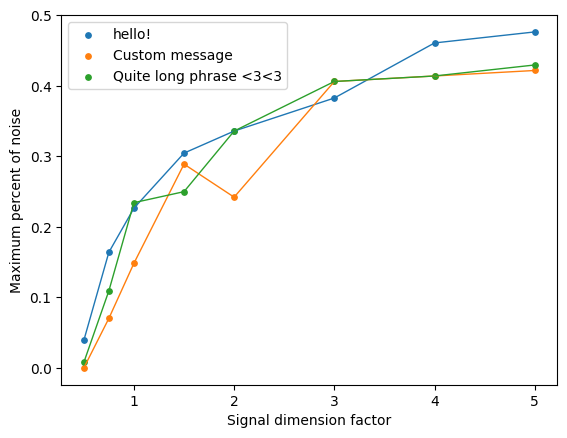

[[0.0390625,
  0.1640625,
  0.2265625,
  0.3046875,
  0.3359375,
  0.3828125,
  0.4609375,
  0.4765625],
 [0.0,
  0.0703125,
  0.1484375,
  0.2890625,
  0.2421875,
  0.40625,
  0.4140625,
  0.421875],
 [0.0078125,
  0.109375,
  0.234375,
  0.25,
  0.3359375,
  0.40625,
  0.4140625,
  0.4296875]]

In [111]:
plot_signal_dim_factors(["hello!", "Custom message", "Quite long phrase <3<3"],
                        [0.5, 0.75, 1, 1.5, *range(2, 6)], seed=420)

In [114]:
find_noise_level_binary(
"""Надо любить жизнь больше, чем смысл жизни.
- Достоевский""", signal_dim_factor=2,  seed=420)

 70%|███████   | 7/10 [04:20<01:51, 37.24s/it, norm_error=3.78, max_noise_percent=0.328, current_noise_percent=0.336, comp_result=0]  


0.328125

## Question 6

*Q6: Now implement the Dikin’s method presented at the end of the first part of the course to
solve problem (1). Compare the results obtained between Dikin’s method and the linear
solvers provided by SciPy*

## Question 7

*Q6: Use SciPy’s linear solver by imposing binary variables: can you decipher your message
with a higher noise level?*

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html